# Holdouts Evaluation - Amazon Digital Music
sample from 2014-06 until 2016-11 with 6M cold start incl. only positive rates (4 and 5 *)

In [48]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

# imports

In [49]:
import pandas as pd 
import joblib

from dataset_evaluation_utils import get_namepaths
from data_utils import load_data_print_info

from data import ImplicitData, getBucketsHoldouts
from eval_implicit import EvaluateHoldouts, EvalPrequential 
from recommenders_implicit import ISGD

from plot_utils import recall_heatmap
from data_utils.transfer_learning_scores import *

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

In [50]:
sample = 'sample_2014-06_until_2016-11+cold_start_positive_rates'


sample_year_month = [('2014-06', '%Y-%m'), ('2016-11', '%Y-%m')]
interval_type = 'S'
dump_filename ='amazon_digmusic_dump'
cold_start_buckets = 1

use_data_unique_users = False
frequent_users_thr = 0.75
to_grid_search = False
num_factors = 100
num_iter = 6
learn_rate = 0.1
regularization = 0.1
random_seed = 10

In [51]:
namepaths = get_namepaths(data_name = '_positive_rates_amazon_digitalmusic',
                          data_print_name = 'Amazon Digital Music',
                          sample_year_month = sample_year_month,
                          interval_type = interval_type,
                          dump_filename = dump_filename,
                          frequent_users_thr = frequent_users_thr,
                          cold_start_buckets = cold_start_buckets,
                          use_data_unique_users = use_data_unique_users,
                          to_grid_search = to_grid_search,
                          num_factors = num_factors,
                          num_iter = num_iter,
                          learn_rate = learn_rate,
                          regularization = regularization,
                          random_seed = random_seed,
                          model_print_name = 'ISGD')
namepaths

{'sample_str': '2014-06_until_2016-11+cold_start_fu_0.75',
 'dataset_name': 'sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic',
 'user_col': 'user_id',
 'item_col': 'item_id',
 'output_path': 'output/amazon_digmusic_dump/',
 'data_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_positive_rates_amazon_digitalmusic.csv',
 'use_data_unique_users': False,
 'frequent_users_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_frequent_users_0.75.joblib',
 'cold_start_buckets': 1,
 'to_grid_search': False,
 'num_factors': 100,
 'num_iter': 6,
 'learn_rate': 0.1,
 'regularization': 0.1,
 'random_seed': 10,
 'interval_type': 'S',
 'intervals_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_fu_0.75_semestres.joblib',
 'bucket_freq': 'semesterly',
 'buckets_path': 'output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_fu_0.75_semesterly_buckets.joblib',
 'holdouts_path': 'output/am

data.shape (80660, 4)
number of users 7353
number of items 52849
number of duplicated user-item interactions 3234

           user_id     item_id   timestamp        date
0  A1G1PWJWIVW6UR  B005OFVNTS  1401580800  2014-06-01
1   AQ4B80F0JSBNI  B002B8ZS0Q  1401580800  2014-06-01
2  A3GYWZE27QBMY7  B003RO1N98  1401580800  2014-06-01
3  A2HXYN2R7W1UQW  B000NNB2PG  1401580800  2014-06-01
4   APKXB8GFNRKEF  B000AOAA74  1401580800  2014-06-01


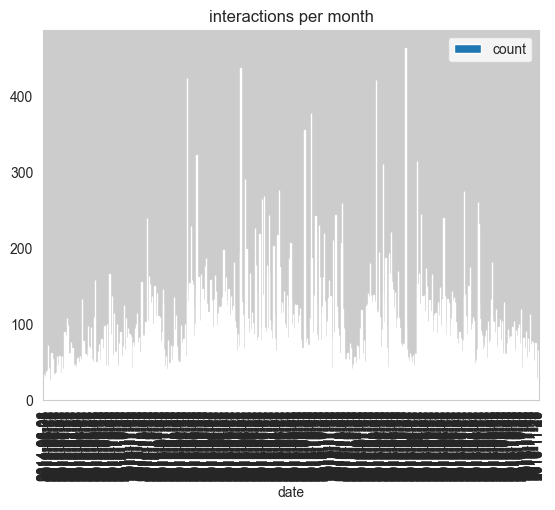

In [52]:
data = load_data_print_info(namepaths['data_path'])

In [53]:
diversity_filepath = namepaths['output_path']+'eval_files/'

In [54]:
rec_lists_b0_h0 = joblib.load(diversity_filepath+'rec_lists_b0_h0.joblib')
print(rec_lists_b0_h0[0])
print('number of rec lists:', len(rec_lists_b0_h0))

[['B001PZ06PS' '0.5036084630168064']
 ['B001386NZE' '0.504954758011992']
 ['B00PJU8VFM' '0.5300628103145297']
 ['B00PBW27VW' '0.5339717351154083']
 ['B00RDEZFN8' '0.5367134409011927']
 ['B009G3S0F4' '0.5513772036287757']
 ['B00T6LGM8I' '0.5687287247543856']
 ['B001IOX1XU' '0.5718044552327285']
 ['B00HB3K55O' '0.5758350167539408']
 ['B00138C98E' '0.5761612550263624']
 ['B00658KG9G' '0.5805775107869356']
 ['B0012QP330' '0.5886001586757581']
 ['B00FZ11C0G' '0.5955553326482207']
 ['B00C3JARCC' '0.5974429158090512']
 ['B00IGIZUGW' '0.5982248029754619']
 ['B00AI3KG0I' '0.6026388892645813']
 ['B00SYTTBMC' '0.6076058554699273']
 ['B00KJJS6HQ' '0.6084093523470404']
 ['B001L0TTS2' '0.6134002633706033']
 ['B00PJU9YSA' '0.6139947052274874']]
number of rec lists: 3382


In [55]:
rl_col = ['bucket_idx','holdout_idx','reclist_idx', namepaths['item_col'], 'score']
rec_list_df = pd.DataFrame(columns=rl_col)

for i, rl in enumerate(rec_lists_b0_h0):
    _ = pd.DataFrame(rec_lists_b0_h0[i], columns = [namepaths['item_col'], 'score'])
    _[rl_col[0]] = 0
    _[rl_col[1]] = 0
    _[rl_col[2]] = i
    # print(_)

    rec_list_df = pd.concat([rec_list_df, _])

rec_list_df

,bucket_idx,holdout_idx,reclist_idx,item_id,score
0,0,0,0,B001PZ06PS,0.5036084630168064
1,0,0,0,B001386NZE,0.504954758011992
2,0,0,0,B00PJU8VFM,0.5300628103145297
3,0,0,0,B00PBW27VW,0.5339717351154083
4,0,0,0,B00RDEZFN8,0.5367134409011927
...,...,...,...,...,...
15,0,0,3381,B002KY6G9I,0.5703635509484708
16,0,0,3381,B00QG30G68,0.5734080374965371
17,0,0,3381,B00SYTMDS6,0.5820801992550826
18,0,0,3381,B00HINPANE,0.5833121376304718


In [56]:
meta_dm = pd.read_csv(namepaths['output_path']+'meta_amazon_digitalmusic.csv')
meta_dm.columns = [namepaths['item_col'], 'n_brand', 'brand']
meta_dm

,item_id,n_brand,brand
0,0001377647,1,John Michael Talbot
1,0001388703,1,Keith Green
2,0001526146,1,Dallas Holm
3,0001527134,1,Don Francisco
4,0001529145,1,Second Chapter of Acts
...,...,...,...
49228,B01HH68B96,1,THE OUTLAWS
49229,B01HH7D5KU,1,FUTURE
49230,B01HHGQXI2,1,Tori Amos
49231,B01HHRIKKK,1,EXO


In [57]:
meta_rec = pd.merge(rec_list_df, meta_dm, 
                    how='left')
meta_rec

,bucket_idx,holdout_idx,reclist_idx,item_id,score,n_brand,brand
0,0,0,0,B001PZ06PS,0.5036084630168064,NaN,NaN
1,0,0,0,B001386NZE,0.504954758011992,NaN,NaN
2,0,0,0,B00PJU8VFM,0.5300628103145297,NaN,NaN
3,0,0,0,B00PBW27VW,0.5339717351154083,NaN,NaN
4,0,0,0,B00RDEZFN8,0.5367134409011927,NaN,NaN
...,...,...,...,...,...,...,...
67635,0,0,3381,B002KY6G9I,0.5703635509484708,NaN,NaN
67636,0,0,3381,B00QG30G68,0.5734080374965371,NaN,NaN
67637,0,0,3381,B00SYTMDS6,0.5820801992550826,NaN,NaN
67638,0,0,3381,B00HINPANE,0.5833121376304718,NaN,NaN


In [58]:
meta_rec.isna().any()

bucket_idx     False
holdout_idx    False
reclist_idx    False
item_id        False
score          False
n_brand         True
brand           True
dtype: bool

In [59]:
meta_dm[meta_dm.brand=='0']

,item_id,n_brand,brand


In [61]:
meta_rec.loc[meta_rec[namepaths['item_col']].isna(), namepaths['item_col']] = '0'
meta_rec.loc[meta_rec.n_brand.isna(), 'n_brand'] = 0
meta_rec.loc[meta_rec.brand.isna(), 'brand'] = '0'

In [62]:
reclist_div = meta_rec[['bucket_idx','holdout_idx','reclist_idx','n_brand']]\
                .groupby(['bucket_idx','holdout_idx','reclist_idx'])\
                    .sum().reset_index()
reclist_div.columns = ['bucket_idx','holdout_idx','reclist_idx', 'diversity']
reclist_div

,bucket_idx,holdout_idx,reclist_idx,diversity
0,0,0,0,2.0
1,0,0,1,0.0
2,0,0,2,1.0
3,0,0,3,3.0
4,0,0,4,0.0
...,...,...,...,...
3377,0,0,3377,2.0
3378,0,0,3378,0.0
3379,0,0,3379,0.0
3380,0,0,3380,1.0


In [63]:
meta_rec[meta_rec.reclist_idx==0]

,bucket_idx,holdout_idx,reclist_idx,item_id,score,n_brand,brand
0,0,0,0,B001PZ06PS,0.5036084630168064,0.0,0
1,0,0,0,B001386NZE,0.504954758011992,0.0,0
2,0,0,0,B00PJU8VFM,0.5300628103145297,0.0,0
3,0,0,0,B00PBW27VW,0.5339717351154083,0.0,0
4,0,0,0,B00RDEZFN8,0.5367134409011927,0.0,0
5,0,0,0,B009G3S0F4,0.5513772036287757,0.0,0
6,0,0,0,B00T6LGM8I,0.5687287247543856,0.0,0
7,0,0,0,B001IOX1XU,0.5718044552327285,0.0,0
8,0,0,0,B00HB3K55O,0.5758350167539408,0.0,0
9,0,0,0,B00138C98E,0.5761612550263624,0.0,0


In [64]:
model_data_b0 = joblib.load(diversity_filepath+'model_data_b0.joblib')
model_data_b0

In [65]:
print(model_data_b0.userlist[:3])
print(model_data_b0.itemlist[:3])

['A1G1PWJWIVW6UR', 'AQ4B80F0JSBNI', 'A3GYWZE27QBMY7']
['B005OFVNTS', 'B002B8ZS0Q', 'B003RO1N98']


In [66]:
print(model_data_b0.GetUserInternalId('A1G1PWJWIVW6UR'))
print(model_data_b0.GetUserItems(0))

0
[0, 4357, 11748, 13311, 13410, 4209]


In [68]:
for u in (model_data_b0.userlist[:3]):
    print(model_data_b0.GetUserItems(u, internal=False))
    print(meta_dm.loc[meta_dm[namepaths['item_col']].isin(model_data_b0.GetUserItems(u, internal=False)), 'n_brand'].sum())
    # df (bucket_idx, u, n_seen_items, sum=diversity)

['B005OFVNTS' 'B00384NH0U' 'B004MEWOW2' 'B00A8U0OYO' 'B00CFSAK1E'
 'B00NB4IKTU']
0
['B002B8ZS0Q' 'B009Z1S8WW' 'B000JFF20E' 'B003RKXB2E' 'B000G1M6GY'
 'B003NXCSVK' 'B000DZAH8M' 'B001S0NNSM' 'B0048A54NG' 'B00GIT07BO'
 'B000B361QS' 'B000E1E2RC' 'B000OGQGTY' 'B004KAP4N4' 'B00A9B8EGW'
 'B0115Q49HM' 'B0048W3LGG' 'B003QC6WUQ' 'B00E3T820Y' 'B003XXCKBI'
 'B000VXRH4I' 'B0055YBSDE' 'B00EDRFCQ8' 'B000GFYRH6' 'B001DIN0ZK'
 'B00SU55444' 'B00M13DECK' 'B00DOVQ1JQ' 'B006W0FGS8' 'B0000249HF'
 'B00411CM0K' 'B000WLV7YK' 'B000QR0ETE' 'B000BD8WUQ' 'B000BD6VF4'
 'B000BDBKOQ' 'B000BD8UEO' 'B000BD96LA' 'B000JFF20E' 'B000BD6NHU'
 'B000BD5OPM' 'B000BD6NWK' 'B000BD8XBE' 'B000BD8Y72' 'B000BD6NWK'
 'B000JFF20E' 'B000JFFBJG' 'B000JFBB3G' 'B000TPVJ5Q' 'B003V61GF8'
 'B000K1UN5G' 'B0015AZ81K' 'B00377XX52' 'B000EFIQQG' 'B0015AZF0O'
 'B000A7023I' 'B000VVCF88' 'B00Q7CFZ50' 'B00G2GHA8Q' 'B00G2GHA8Q']
49
['B003RO1N98' 'B0011Z4WT8' 'B00137T3ES' 'B00137QWBK' 'B00CUR29GY'
 'B00137T3ES' 'B0011Z4WT8' 'B00137QWBK' 'B00K5X177C' 'B

In [ ]:
# x axis -> groups n_seen_items

# bin rec list according to the respective user n_seen_items

# y axix -> avg top 20 div

# scatter points of users

In [ ]:
# optimise to read holdouts and buckets
